In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
import seaborn as sns

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
player_price = pd.read_csv('player_price.csv', sep = ",")
player_stats = pd.read_csv('player_stats.csv', sep = ",")
len(player_price), len(player_stats)

(967302, 4600)

In [3]:
player_price["timestamp"] = pd.to_datetime(player_price["timestamp"],unit='ms')

In [4]:
player_price['year'], player_price['month'] = player_price['timestamp'].dt.year, player_price['timestamp'].dt.month
player_price["timestamp"].min()

Timestamp('2016-09-23 00:00:00')

In [5]:
player_price = pd.merge(player_price, player_stats, \
         how = "left", on="player_id")
del player_stats

In [6]:
d = {'gold' : 1, 'silver' : 2, 'bronze' : 3}
player_price['colour'] = player_price['colour'].map(d)

In [7]:
player_price = player_price[player_price['colour'] == 1]

-----------------------------

In [8]:
player_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663441 entries, 0 to 962258
Data columns (total 84 columns):
timestamp          663441 non-null datetime64[ns]
ps_price           663441 non-null int64
xbox_price         663441 non-null int64
player_id          663441 non-null int64
player_name        663441 non-null object
year               663441 non-null int64
month              663441 non-null int64
acceleration       663441 non-null int64
aggression         663441 non-null int64
agility            663441 non-null int64
balance            663441 non-null int64
ball               663441 non-null int64
composure          663441 non-null int64
crossing           663441 non-null int64
curve              663441 non-null int64
defending          663441 non-null int64
diving             663441 non-null int64
dribbling          663441 non-null int64
finishing          663441 non-null int64
fk                 663441 non-null int64
handling           663441 non-null int64
heading           

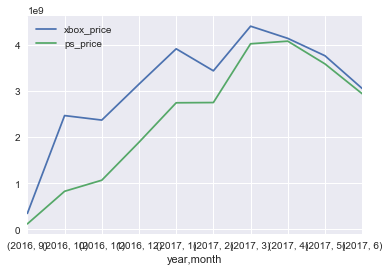

In [9]:
player_price[["year","month","xbox_price","ps_price"]].groupby(['year',"month"]).sum().plot()


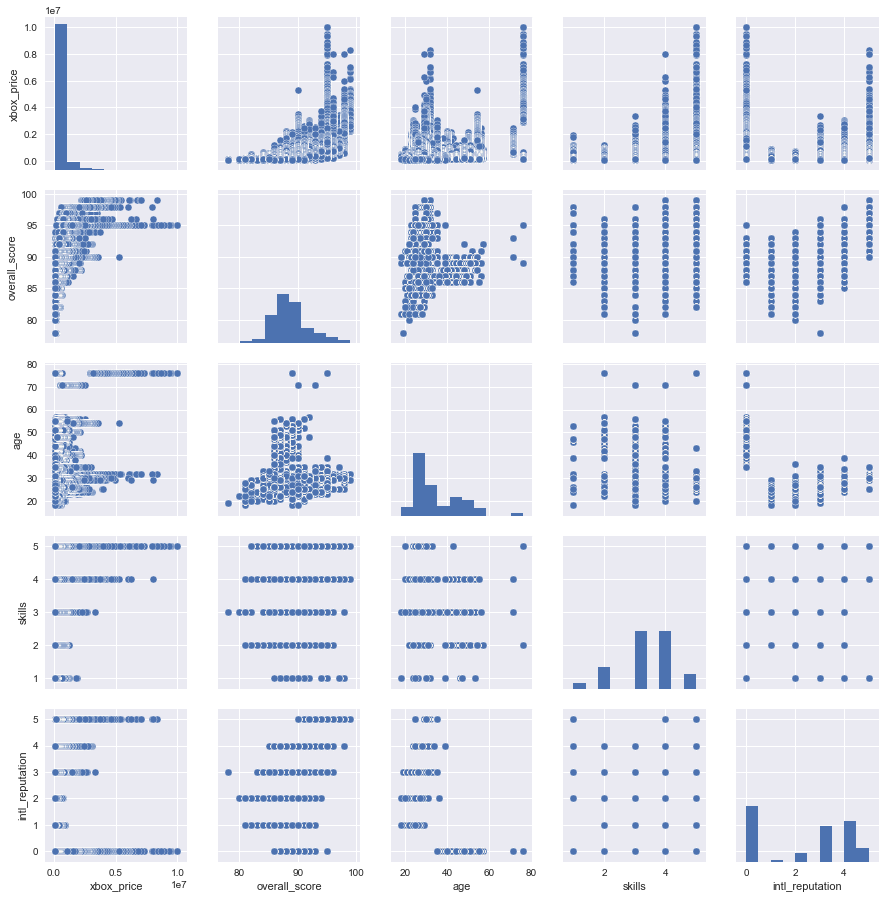

In [10]:
cols = ["xbox_price", "overall_score", "age","skills","intl_reputation"]
sns_plot = sns.pairplot(player_price[cols][player_price["xbox_price"]>=100000]) #

sns_plot.savefig('pairplot.png')

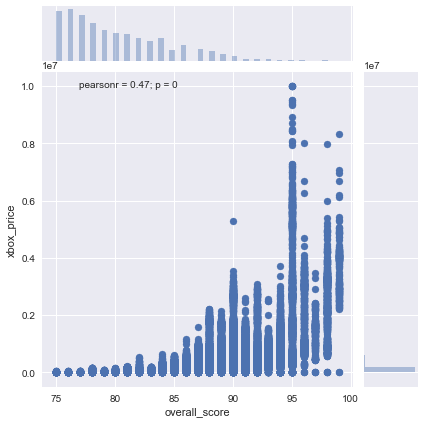

In [11]:
sns.jointplot("overall_score", "xbox_price", data=player_price)

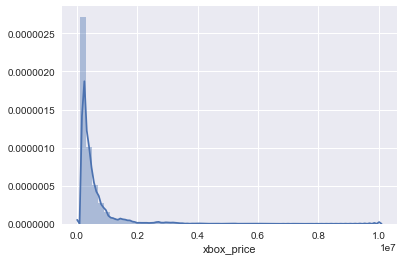

In [12]:
sns.distplot(player_price["xbox_price"][player_price["xbox_price"]>=100000])

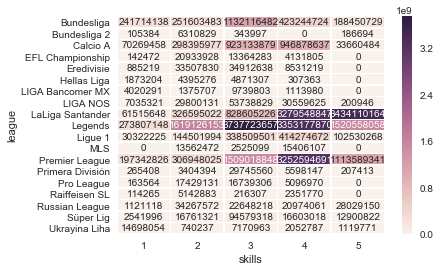

In [13]:
platform_genre_sales = player_price.pivot_table(
                        index='league', 
                        columns='skills', 
                        values='xbox_price', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".0f", linewidths=.5)

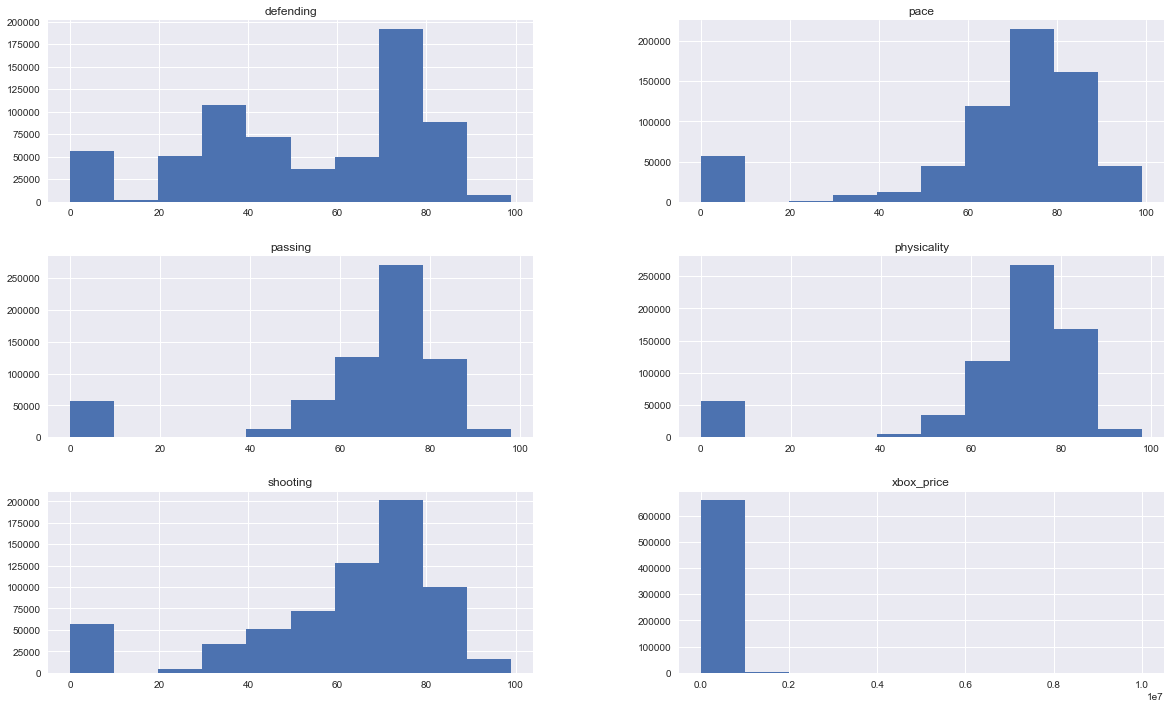

In [14]:
scills_df = list(player_price[["pace","shooting","passing","defending","physicality"]+['xbox_price']])
player_price[scills_df].hist(figsize=(20,12));

## t-SNE embedding

In [15]:
test = player_price[["pace","shooting","passing","defending","physicality",\
                     "xbox_price"]][((player_price["xbox_price"]>=200000)&\
                                    (player_price["xbox_price"]<3000000))].sample(frac=1).reset_index(drop=True)

In [16]:
test = test[:12000]

In [17]:
X = MinMaxScaler().fit_transform(
            test[["pace","shooting","passing",\
                          "defending","physicality"]])
y = test['xbox_price'].values
y.max()

2997800

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 0.8931991, gradient norm = 0.0127298
[t-SNE] Iterati

In [19]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'xbox_price'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with pace, shooting, passing, defending, physicality')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')